## **LOCAL BINARY PATTERNS (LBP)**

* Local Binary Patterns are used to **characterize the texture and pattern of an image/object in an image**.
* LBPs **compute a local representation of texture**.
* This local representation is **performed by comparing each pixel with its surrounding neighborhood of pixel values**.

* LBPs are **implemented in both mahotas and scikit-image**.
* Both these implementations work well; however, I **prefer the scikit-image** implementation which is,
  1.   easier to use and,
  2.   implements recent extensions to LBPs which further improves rotation invariance, leading to higher accuracy and smaller feature vector sizes.

### **Steps in Local Binary Pattern:**
* The **first step** in constructing a LBP texture descriptor is to  **convert the image to grayscale**.
* For **each pixel in the grayscale image**, we **select a neighborhood of size r surrounding the center pixel**.
* A **LBP value is then calculated for this center pixel** and **stored in an output 2D array with the same width and height as our input image**.

Mounted at /content/drive


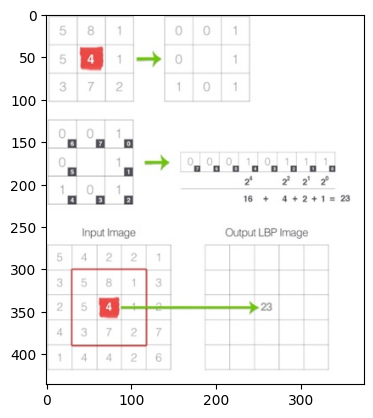

In [1]:
# prompt: add an image from google drive and display it

from google.colab import drive
drive.mount('/content/drive')

# Load the image from Google Drive
image_path = '/content/drive/MyDrive/MIT/Work/Machine_Learning/Google_Colab/Machine_Learning/Image_Descriptors/Image_Descriptors_LBP/LBP.jpg'

# Import necessary libraries
import matplotlib.pyplot as plt

# Read the image
image = plt.imread(image_path)

# Display the image
plt.imshow(image)
plt.show()


* For **example**, consider a **8 pixel neighborhood surrounding a pixel** and threshold it against its neighborhood of 8 pixels.
* **If the intensity of the center pixel is greater-than-or-equal to its neighbor, then set the value to 1; otherwise, set it to 0.**
* **8-bit binary neighborhood of the central pixel and converting it into a decimal representation.**
* **Calculated value is stored in an output array with the same width and height as the original image.**


* A **LBP** is considered to be **uniform if it has at most two 0-1 or 1-0 transitions.**
* For **example**, the pattern 00001000  (2 transitions) and 10000000  (1 transition) are both considered uniform patterns since they contain at most two 0-1 to 1-0 transitions.
* 01010010  (6 transitions) on the other hand is not considered a uniform pattern since it has six 0-1 or 1-0 transitions.

* There are **two primary benefits** of this original LBP algorithm proposed by Ojala et al.
* The **first benefit** is that **examining the simple 3 x 3 neighborhood is extremely fast and efficient** — it only **requires a simple thresholding test** and very quick bit operations.
* The **second benefit** is working at such a **small scale we are able to capture extremely fine grained details in the image**.
* However, being able to capture details at a small scale also is the **biggest drawback of the algorithm** — we **cannot capture details at varying scales**, only the fixed 3 x 3 scale.

* To handle this, an **extension to the original LBP implementation was proposed to handle variable neighborhood sizes.**
* To account for variable neighborhood sizes, **two parameters were introduced**:

    1.	The **number of points p in a circularly symmetric neighborhood** to consider (thus removing relying on a square neighborhood).
    
    2.	The **radius of the circle r**, which allows us to account for different scales.

* Given circular radius r and number of points p, the **goal is now to align the neighbors of each pixel on the circle to capture the following neighbors called “prototypes”**, which are the **unique set of possible binary patterns** that can occur for a given radius r and number of points p.
* Below we can see the **36 unique rotation invariant binary patterns that can occur in a neighborhood of p=8 points**, where **black circles have a bit value of 0** and **white circles have a bit value of 1**.

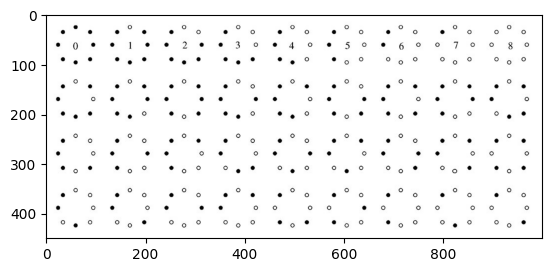

In [2]:
# Load the image from Google Drive
image_path = '/content/drive/MyDrive/MIT/Work/Machine_Learning/Google_Colab/Machine_Learning/Image_Descriptors/Image_Descriptors_LBP/LBP4.jpg'

# Read the image
image = plt.imread(image_path)

# Display the image
plt.imshow(image)
plt.show()

* The **36 unique rotation invariant binary patterns when n=8**. the **top row** of **9 patterns** are especially important as they **represent uniform patterns, containing at most two 0-1 or 1-0 transitions**, making them even **more robust to changes in rotation**.
* The **LBP pattern marked as 0 detects bright regions in an image** (since it is surrounded by pixel intensity pixels that are smaller than itself).
* The **LBP pattern marked 8 detects dark spots in the image**, since all pixels surrounding it are larger.
* Finally, the **pattern marked 4 detects edge regions in the image** where there is a transition from dark to light.

* The **number of uniform prototypes** in a Local Binary Pattern is completely **dependent on the number of points p**.
* As the **value of p increases, so will the dimensionality of your resulting histogram**.
* However, for the time being simply keep in mind that **given the number of points p in the LBP, there are p + 1 uniform patterns.**
* The **final dimensionality of the histogram is thus p + 2**, where the **added entry tabulates all patterns that are not uniform**.
* It’s also important to keep in mind the effect of both the radius r and the number of points p.
* The **more points p you sample, the more patterns you can encode**, but at the same time you **increase your computational cost**.
* On the other hand, if you **increase your radius size r then you can capture larger texture details in the image**.
* However, **if you increase r without increasing p as well, then you’ll lose the locally discriminative power of the LBP descriptor**.
* In general, **you will want to increase or decrease both r and p together**.
* Finally, it’s **important to consider the spatial information** of the LBP.
* If we took **all LBP codes and constructed a histogram of them we would lose all spatial information**, similar to constructing a color histogram.
* On the other hand, if we **divide our image into blocks, extract LBPs for each block, and concatenate them together, we are able to create a descriptor that encodes spatial information too**.
	The **spatial encoding step** is certainly not necessary, but for tasks such as **face recognition it’s crucial**.


#### **Program**: Mini fashion search engine: how to rank pieces of clothing for similarity based on texture. The goal here is to submit each of the query images to our fashion search engine, have our image search engine rank the images using Local Binary Patterns, and then return the most similar images based on the texture/pattern.

In [3]:
# import the necessary packages
from __future__ import print_function
from imutils import paths
from google.colab.patches import cv2_imshow
import numpy as np
import cv2
from skimage import feature

In [4]:
# initialize the local binary patterns descriptor and initialize the index dictionary where the image
# filename is the key and the features are the value
# define a dictionary called index , where the key to the dictionary is the unique shirt image
# filename and the value is the extracted LBPs. We’ll be using this dictionary to store our
# extracted feature and aid us in comparing the query image to our dataset.
index = {}
radius=8
numPoints=24

In [5]:
def describe(image, eps=1e-7):
	# compute the Local Binary Pattern representation of the image, and then use the LBP
  # representation to build the histogram of patterns.
	# LBPs require two parameters: the radius of the pattern surrounding the central pixel,
  # along with the number of points along the outer radius.
	# The uniform  method indicates that we are computing the rotation invariant form of
  # LBPs using the 25 rotation invariant prototypes (assuming a value of p=24)
	# However, the lbp  variable returned by the local_binary_pattern  function is not directly
  # usable as a feature vector. Instead, lbp  is a 2D array with the same width and height
  # as our input image — each of the values inside lbp  ranges from [0, 25], a value for
  # each for the 25 possible rotation invariant LBP prototypes, along with an extra
  # dimension for all patterns that are not uniform, yielding a total of 26 unique possible values
	# numpy.ravel() – returns a contiguous flattened array.
	# bins and range value does not include numPoints+3 and numPoints+2 in computation
	# Thus, to construct the actual feature vector, we need to make a call to np.histogram
  # which counts the number of times each of the LBP prototypes appears. The returned
  # histogram is 26-d, an integer count for each of prototypes. We then take this
  # histogram, normalize it such that it sums to 1, and then return it to our calling function.
	lbp = feature.local_binary_pattern(image,numPoints, radius, method="uniform")
	(hist, _) = np.histogram(lbp.ravel(), bins=range(0, numPoints + 3), range=(0, numPoints + 2))
	# optionally, normalize the histogram
	hist = hist.astype("float")
	hist /= (hist.sum() + eps)

	# return the histogram of Local Binary Patterns
	return hist

In [ ]:
# loop over the shirt images
# We simply loop over the images, extract the LBPs, and update the index  dictionary.
for imagePath in paths.list_images("/content/drive/MyDrive/MIT/Work/Machine_Learning/Google_Colab/Machine_Learning/Image_Descriptors/Image_Descriptors_LBP/shirts"):
	# load the image, convert it to grayscale, and describe it
	image = cv2.imread(imagePath)
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	hist = describe(gray)

	# update the index dictionary
	filename = imagePath[imagePath.rfind("\\") + 1:]
	index[filename] = hist
	print (index)

In [ ]:
# load the query image and extract Local Binary Patterns from it
query = cv2.imread("/content/drive/MyDrive/MIT/Work/Machine_Learning/Google_Colab/Machine_Learning/Image_Descriptors/Image_Descriptors_LBP/queries/query_01.jpg")
queryFeatures = describe(cv2.cvtColor(query, cv2.COLOR_BGR2GRAY))

# show the query image and initialize the results dictionary
cv2_imshow(query)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
results = {}

# loop over the index
for (k, features) in index.items():
	# compute the chi-squared distance between the current features and the query
	# features, then update the dictionary of results
	# The chi-squared distance is an excellent choice for this problem as it’s well suited for
  # comparing histograms. Smaller distance indicates higher similarity.
	d = 0.5 * np.sum(((features - queryFeatures) ** 2) / (features + queryFeatures + 1e-10))
	results[k] = d

# sort the results
# keeping the 3 most similar results
results = sorted([(v, k) for (k, v) in results.items()])[:3]
print (results)

In [ ]:
# loop over the results
for (i, (score, filename)) in enumerate(results):
	# show the result image
	print("#%d. %s: %.4f" % (i + 1, filename, score))
	image = cv2.imread(filename)
	cv2_imshow(image)
	cv2.waitKey(0)
cv2.destroyAllWindows()